In [124]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import nibabel as nib
import scipy
from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import mode
from sklearn.utils.extmath import weighted_mode
from skimage import transform as tf
from skimage.transform import warp, AffineTransform
from sklearn.metrics import mean_absolute_error
from skimage.restoration import denoise_bilateral, estimate_sigma, denoise_nl_means
import pandas as pd
import cv2
import skimage

In [152]:
def get_middle_slice(img):
    img_data = img.get_fdata()
    slice_2 = img_data[:, :, len(img_data[0][0])//2]
    return slice_2.reshape((256, 256))

# get paths to images
path = os.getcwd()
training_path = path + '/Data/Training'
validation_path = path + '/Data/Validation'
testing_path = path + '/Data/Testing'

# load images
img1 = nib.load(training_path + '/IBSR_01/images/analyze/IBSR_01_ana.img')
img2 = nib.load(training_path + '/IBSR_02/images/analyze/IBSR_02_ana.img')
img3 = nib.load(training_path + '/IBSR_03/images/analyze/IBSR_03_ana.img')
img4 = nib.load(training_path + '/IBSR_04/images/analyze/IBSR_04_ana.img')
img5 = nib.load(training_path + '/IBSR_05/images/analyze/IBSR_05_ana.img')
img6 = nib.load(training_path + '/IBSR_06/images/analyze/IBSR_06_ana.img')
img7 = nib.load(validation_path + '/IBSR_07/images/analyze/IBSR_07_ana.img')
img8 = nib.load(testing_path + '/IBSR_08/images/analyze/IBSR_08_ana.img')
img9 = nib.load(testing_path + '/IBSR_09/images/analyze/IBSR_09_ana.img')
img10 = nib.load(testing_path + '/IBSR_10/images/analyze/IBSR_10_ana.img')
img11 = nib.load(testing_path + '/IBSR_11/images/analyze/IBSR_11_ana.img')
img12 = nib.load(testing_path + '/IBSR_12/images/analyze/IBSR_12_ana.img')
img13 = nib.load(testing_path + '/IBSR_13/images/analyze/IBSR_13_ana.img')
img14 = nib.load(testing_path + '/IBSR_14/images/analyze/IBSR_14_ana.img')
img15 = nib.load(validation_path + '/IBSR_15/images/analyze/IBSR_15_ana.img')
img16 = nib.load(testing_path + '/IBSR_16/images/analyze/IBSR_16_ana.img')
img17 = nib.load(testing_path + '/IBSR_17/images/analyze/IBSR_17_ana.img')
img_array = np.array([img1, img2, img3, img4, img5, img6, img7, img8, img9, img10, 
                      img11, img12, img13, img14, img15, img16, img17])

img_seg1 = nib.load(training_path + '/IBSR_01/segmentation/analyze/IBSR_01_seg_ana.img')
img_seg2 = nib.load(training_path + '/IBSR_02/segmentation/analyze/IBSR_02_seg_ana.img')
img_seg3 = nib.load(training_path + '/IBSR_03/segmentation/analyze/IBSR_03_seg_ana.img')
img_seg4 = nib.load(training_path + '/IBSR_04/segmentation/analyze/IBSR_04_seg_ana.img')
img_seg5 = nib.load(training_path + '/IBSR_05/segmentation/analyze/IBSR_05_seg_ana.img')
img_seg6 = nib.load(training_path + '/IBSR_06/segmentation/analyze/IBSR_06_seg_ana.img')
img_seg7 = nib.load(validation_path + '/IBSR_07/segmentation/analyze/IBSR_07_seg_ana.img')
img_seg15 = nib.load(validation_path + '/IBSR_15/segmentation/analyze/IBSR_15_seg_ana.img')
img_seg_array = np.array([img_seg1, img_seg2, img_seg3, img_seg4, img_seg5, img_seg6, img_seg7, img_seg15])

training_images, training_segments = [], []
validation_images, validation_segments = [], []
testing_images = []

for i in range(0, 6): 
    training_images.append(get_middle_slice(img_array[i]))
for i in [6, 14]: 
    validation_images.append(get_middle_slice(img_array[i]))
for i in [7, 8, 9, 10, 11, 12, 13, 15, 16]: 
    testing_images.append(get_middle_slice(img_array[i]))
for i in range(len(img_seg_array)):
    if i < 6:
        training_segments.append(get_middle_slice(img_seg_array[i]))
    else:
        validation_segments.append(get_middle_slice(img_seg_array[i]))

In [126]:
def transform(moving_img, scale_x, scale_y, angle, t_c, t_r, grid_size):
    h, w = moving_img.shape[0], moving_img.shape[1]
    o_h, o_w = grid_size[0], grid_size[1]

    shift_y, shift_x, temp = (np.array((o_h, o_w, 1)) - 1) / 2.
    shift_first = skimage.transform.SimilarityTransform(translation=[-shift_x, -shift_y])
    shift_back = skimage.transform.SimilarityTransform(translation=[shift_x, shift_y])    

    affine = AffineTransform(scale = (scale_x, scale_y), rotation = np.deg2rad(angle), translation = (t_r, t_c))
    transformed_img = warp(moving_img, (shift_first + affine + shift_back).inverse, order=1, clip=False, preserve_range=True)
    return transformed_img

In [127]:
def loss_MSE(parameters, moving_img, fixed_img): 
    transformed_img = transform(moving_img, *parameters, fixed_img.shape)
    temp1 = np.array(fixed_img).flatten()
    temp2 = np.array(transformed_img).flatten()
    loss = np.sum(np.power(temp1-temp2, 2))
    return loss

def loss_MAE(parameters, moving_img, fixed_img): 
    transformed_img = transform(moving_img, *parameters, fixed_img.shape)
    temp1 = np.array(fixed_img).flatten()
    temp2 = np.array(transformed_img).flatten()
    loss = mean_absolute_error(temp1, temp2)
    return loss

def loss(parameters, moving_img, fixed_img):
    transformed_img = transform(moving_img, *parameters, fixed_img.shape)
    output = skimage.measure.compare_ssim(skimage.color.rgb2gray(transformed_img), skimage.color.rgb2gray(fixed_img))     
    return -output

In [128]:
def optimize(fixed_img, moving_img):
    optimized_params = scipy.optimize.minimize(loss, (1,1,0,0,0), args = (fixed_img,moving_img), method = 'BFGS')
    optimized_img = transform(moving_img, *optimized_params.x, fixed_img.shape)
    return optimized_params.x, optimized_img

In [129]:
def geometricRegistration(fixed_img, moving_img):
    height, width = fixed_img.shape[0], fixed_img.shape[1]
    normalizedImg = np.zeros((height,width))
    normalized_fixed_img = cv2.normalize(fixed_img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    normalizedImg = np.zeros((height,width))
    normalized_moving_img = cv2.normalize(moving_img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    opt_params, transf_img = optimize(normalized_fixed_img,normalized_moving_img)
    return opt_params, transf_img  

In [130]:
def filter_moving_imgs(moving_img): 
    sigma_est = estimate_sigma(moving_img, multichannel=False, average_sigmas=True)
    moving_img = denoise_nl_means(moving_img, sigma = 1.0)
    return moving_img

In [131]:
for i in range(len(training_images)):
    training_images[i] = filter_moving_imgs(training_images[i])
    print(i) # keep track of progress
for i in range(len(validation_images)):
    validation_images[i] = filter_moving_imgs(validation_images[i])
    print(i) # keep track of progress

0
1
2
3
4
5
0
1


In [132]:
training_opt_params, val_opt_params = [], []
count = 0
for fixed_img in testing_images:
    print(count)
    for moving_img in training_images: 
        op, tf = geometricRegistration(fixed_img, moving_img)
        training_opt_params.append(op)
    for moving_img in validation_images: 
        op, tf = geometricRegistration(fixed_img, moving_img)
        val_opt_params.append(op)
    count += 1

0


/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

1


/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

2


/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


3


/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

4


/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

5


/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

6


/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

7


/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

8


/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/Users/samhong/miniconda3/lib/python3.7/site-packages/ipyker

In [133]:
seg_0 = [transform(training_segments[i], *training_opt_params[i], testing_images[0].shape) for i in range(6)]
seg_1 = [transform(training_segments[i], *training_opt_params[6+i], testing_images[1].shape) for i in range(6)]
seg_2 = [transform(training_segments[i], *training_opt_params[12+i], testing_images[2].shape) for i in range(6)]
seg_3 = [transform(training_segments[i], *training_opt_params[18+i], testing_images[3].shape) for i in range(6)]
seg_4 = [transform(training_segments[i], *training_opt_params[24+i], testing_images[4].shape) for i in range(6)]
seg_5 = [transform(training_segments[i], *training_opt_params[30+i], testing_images[5].shape) for i in range(6)]
seg_6 = [transform(training_segments[i], *training_opt_params[36+i], testing_images[6].shape) for i in range(6)]
seg_7 = [transform(training_segments[i], *training_opt_params[42+i], testing_images[7].shape) for i in range(6)]
seg_8 = [transform(training_segments[i], *training_opt_params[48+i], testing_images[8].shape) for i in range(6)]

segv_0 = [transform(validation_segments[i], *val_opt_params[i], testing_images[0].shape) for i in range(2)]
segv_1 = [transform(validation_segments[i], *val_opt_params[i+2], testing_images[0].shape) for i in range(2)]
segv_2 = [transform(validation_segments[i], *val_opt_params[i+4], testing_images[0].shape) for i in range(2)]
segv_3 = [transform(validation_segments[i], *val_opt_params[i+6], testing_images[0].shape) for i in range(2)]
segv_4 = [transform(validation_segments[i], *val_opt_params[i+8], testing_images[0].shape) for i in range(2)]
segv_5 = [transform(validation_segments[i], *val_opt_params[i+10], testing_images[0].shape) for i in range(2)]
segv_6 = [transform(validation_segments[i], *val_opt_params[i+12], testing_images[0].shape) for i in range(2)]
segv_7 = [transform(validation_segments[i], *val_opt_params[i+14], testing_images[0].shape) for i in range(2)]
segv_8 = [transform(validation_segments[i], *val_opt_params[i+16], testing_images[0].shape) for i in range(2)]

reg_segs0 = np.zeros((8, 256, 256)) 
reg_segs1 = np.zeros((8, 256, 256))
reg_segs2 = np.zeros((8, 256, 256)) 
reg_segs3 = np.zeros((8, 256, 256))
reg_segs4 = np.zeros((8, 256, 256)) 
reg_segs5 = np.zeros((8, 256, 256))
reg_segs6 = np.zeros((8, 256, 256)) 
reg_segs7 = np.zeros((8, 256, 256))
reg_segs8 = np.zeros((8, 256, 256))

for i in range (6):
    reg_segs0[i,:,:] = seg_0[i]
    reg_segs1[i,:,:] = seg_1[i]
    reg_segs2[i,:,:] = seg_2[i]
    reg_segs3[i,:,:] = seg_3[i]
    reg_segs4[i,:,:] = seg_4[i]
    reg_segs5[i,:,:] = seg_5[i]
    reg_segs6[i,:,:] = seg_6[i]
    reg_segs7[i,:,:] = seg_7[i]
    reg_segs8[i,:,:] = seg_8[i]
    
for i in range (2):
    reg_segs0[i+6,:,:] = segv_0[i]
    reg_segs1[i+6,:,:] = segv_1[i]
    reg_segs2[i+6,:,:] = segv_2[i]
    reg_segs3[i+6,:,:] = segv_3[i]
    reg_segs4[i+6,:,:] = segv_4[i]
    reg_segs5[i+6,:,:] = segv_5[i]
    reg_segs6[i+6,:,:] = segv_6[i]
    reg_segs7[i+6,:,:] = segv_7[i]
    reg_segs8[i+6,:,:] = segv_8[i]

In [142]:
def MFTL(imgs):
    modes = np.zeros((256,256))

    for i in range(len(imgs[0])): 
        for j in range(len(imgs[0][0])): 
            m, count = mode([imgs[x][i][j] for x in range(len(imgs))])
            if count == 1 or m == 0: 
                if count == 1: 
                    m = np.sum([imgs[x][i][j] for x in range(len(imgs))])//8
                else: 
                    if count < 4:
                        m = np.max([imgs[x][i][j] for x in range(len(imgs))])
            modes[i][j] = m
    return modes

def MFTL_v0(imgs):
    modes, count = mode(imgs) # Default is axis=0, don't care about count output
    modes = modes.reshape((256, 256))
    
    return modes

In [135]:
segs = [reg_segs0, reg_segs1, reg_segs2, reg_segs3, 
        reg_segs4, reg_segs5, reg_segs6, reg_segs7, reg_segs8]
MFTLs = []
for seg in segs: 
    MFTLs.append(MFTL(seg))

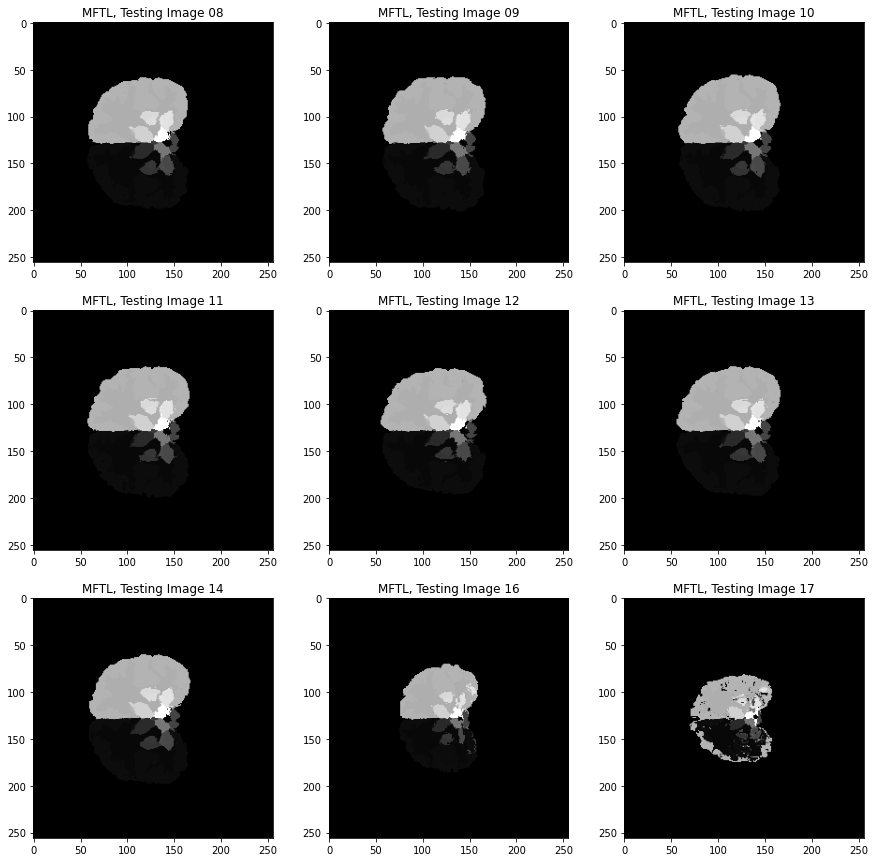

In [136]:
figcount = 1
label = ['08','09','10','11','12','13','14','16','17']
w = 10
h = 10
fig = plt.figure(figsize = (15, 15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.title('MFTL, Testing Image ' + label[i-1])
    plt.imshow(MFTLs[i-1].squeeze(), cmap = 'gray')
plt.show()
fig.savefig('MFTL.png')

In [137]:
# for kaggle
def format_seg(img):
    img = np.array(img)
    temp1 = np.zeros(img.shape)
    temp1[img == 2] = 1
    
    temp2 = np.zeros(img.shape)
    temp2[img == 3] = 1
    
    temp3 = np.zeros(img.shape)
    temp3[img == 41] = 1
    
    temp4 = np.zeros(img.shape)
    temp4[img == 42] = 1
    
    return np.array((temp1, temp2, temp3, temp4))
    
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [123]:
masks2, masks3, masks41, masks42 = [], [], [], []

for MFTL in MFTLs: 
    masks = format_seg(MFTL)
    masks2.append(masks[0])
    masks3.append(masks[1])
    masks41.append(masks[2])
    masks42.append(masks[3])
    
data = []
for i in range(9):
    data.append(rle_encode(masks2[i]))
    data.append(rle_encode(masks3[i]))
    data.append(rle_encode(masks41[i]))
    data.append(rle_encode(masks42[i]))
    
# labels 
regions = ['-left-wm', '-left-cortex', '-right-wm', '-right-cortex']
nums = ['8','9','10','11','12','13','14','16','17']
labels = []

for num in nums:
    for reg in regions:
        labels.append(num + reg)
        
df = pd.DataFrame({"Id": labels, "Predicted": data})
df.to_csv('submission.csv', index = False) 

In [138]:
# some plots for the paper
sigma_est = estimate_sigma(testing_images[0], multichannel=False, average_sigmas=True)
print(sigma_est)
moving_img = denoise_bilateral(testing_images[0], sigma_color = 1.0, multichannel=False)
moving_img1 = denoise_nl_means(testing_images[0], sigma = 1.0)

1.272448061995835


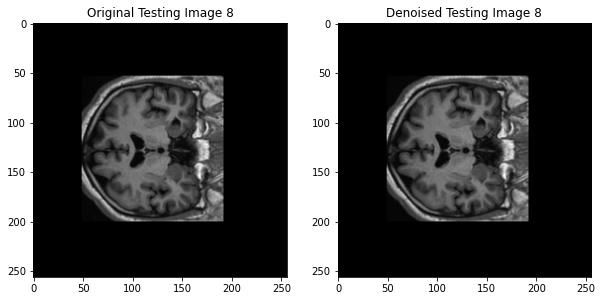

In [98]:
fig = plt.figure(figsize = (10, 10))
fig.add_subplot(121)
plt.title('Original Testing Image 8')
plt.imshow(testing_images[0].squeeze(), cmap = 'gray')

fig.add_subplot(122)
plt.title('Denoised Testing Image 8')
plt.imshow(moving_img1.squeeze(), cmap = 'gray')

fig.savefig('filter.png')

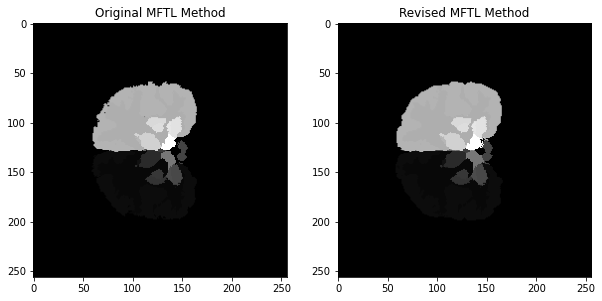

In [143]:
fig = plt.figure(figsize = (10, 10))
fig.add_subplot(121)
plt.title('Original MFTL Method')
plt.imshow(MFTL_v0(segs[0]).squeeze(), cmap = 'gray')

fig.add_subplot(122)
plt.title('Revised MFTL Method')
plt.imshow(MFTL(segs[0]).squeeze(), cmap = 'gray')

fig.savefig('comp_MFTL.png')

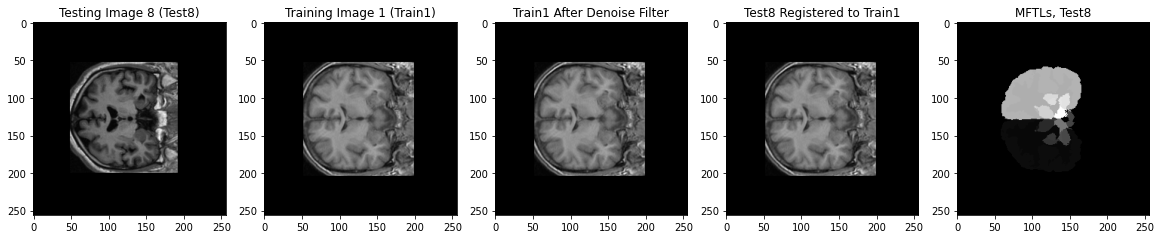

In [151]:
fig = plt.figure(figsize = (20, 20))
fig.add_subplot(151)
plt.title('Testing Image 8 (Test8)')
plt.imshow(testing_images[0].squeeze(), cmap = 'gray')

fig.add_subplot(152)
plt.title('Training Image 1 (Train1)')
plt.imshow(get_middle_slice(img1).squeeze(), cmap = 'gray')

fig.add_subplot(153)
plt.title('Train1 After Denoise Filter')
plt.imshow(training_images[0].squeeze(), cmap = 'gray')

fig.add_subplot(154)
plt.title('Test8 Registered to Train1')
plt.imshow(training_images[0].squeeze(), cmap = 'gray')

fig.add_subplot(155)
plt.title('MFTLs, Test8')
plt.imshow(MFTLs[0].squeeze(), cmap = 'gray')

fig.savefig('totalimg.png')